# Demonstration of MCE IRL code & environments

This is just tabular environments & vanilla MCE IRL.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import copy

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy

import imitation.tabular_irl as tirl
import imitation.model_env as menv

sns.set(context='notebook')

# IRL on a random MDP

Testing both linear reward models & MLP reward models.

In [2]:
mdp = menv.RandomMDP(
    n_states=16,
    n_actions=3,
    branch_factor=2,
    horizon=10,
    random_obs=True,
    obs_dim=5,
    generator_seed=42)
V, Q, pi = tirl.mce_partition_fh(mdp)
Dt, D = tirl.mce_occupancy_measures(mdp, pi=pi)
demo_counts = D @ mdp.observation_matrix
obs_dim, = demo_counts.shape

In [3]:
rmodel = tirl.LinearRewardModel(obs_dim)
opt = tirl.SGD(rmodel, alpha_sched=0.05)
final_weights, D_fake = tirl.maxent_irl(
    mdp, opt, rmodel, D, linf_eps=1e-1)

Occupancy measure error@iter   0: 2.545004 (||params||=3.049661, ||grad||=30.197654, ||E[dr/dw]||=14.742529)


In [4]:
rmodel = tirl.MLPRewardModel(obs_dim, [32, 32])
opt = tirl.SGD(rmodel, alpha_sched=0.5)
final_weights, D_fake = tirl.maxent_irl(
    mdp, opt, rmodel, D, linf_eps=1e-2)

/home/sam/.virtualenvs/ray-irl/lib/python3.6/site-packages/jax/lib/xla_bridge.py:144: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Occupancy measure error@iter   0: 2.576432 (||params||=9.398392, ||grad||=55.881441, ||E[dr/dw]||=26.533055)


# Same thing, but on grid world

The true reward here is not linear in the reduced feature space (i.e $(x,y)$ coordinates). Finding an appropriate linear reward is impossible (as I will demonstration), but an MLP should Just Work(tm).

Occupancy measure error@iter   0: 1.448530 (||params||=2.072475, ||grad||=2.404023, ||E[dr/dw]||=3.126840)
Occupancy measure error@iter  100: 1.144563 (||params||=20.502038, ||grad||=0.016709, ||E[dr/dw]||=5.174918)
Occupancy measure error@iter  200: 1.148081 (||params||=21.712552, ||grad||=0.001352, ||E[dr/dw]||=5.183923)
Occupancy measure error@iter  300: 1.147188 (||params||=22.445078, ||grad||=0.000857, ||E[dr/dw]||=5.184392)
Occupancy measure error@iter  400: 1.146649 (||params||=22.918414, ||grad||=0.000568, ||E[dr/dw]||=5.184642)
Occupancy measure error@iter  500: 1.146309 (||params||=23.235560, ||grad||=0.000387, ||E[dr/dw]||=5.184800)
Occupancy measure error@iter  600: 1.146086 (||params||=23.452842, ||grad||=0.000268, ||E[dr/dw]||=5.184903)
Occupancy measure error@iter  700: 1.145936 (||params||=23.603868, ||grad||=0.000187, ||E[dr/dw]||=5.184973)
Occupancy measure error@iter  800: 1.145833 (||params||=23.709860, ||grad||=0.000132, ||E[dr/dw]||=5.185020)


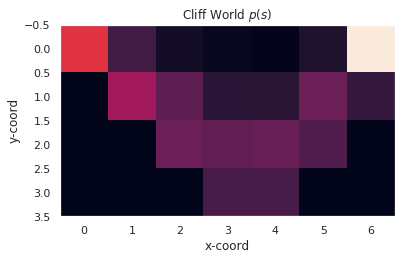

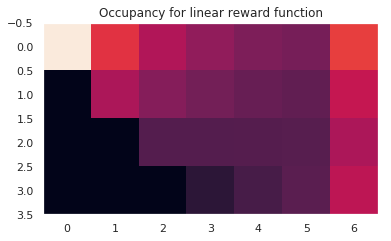

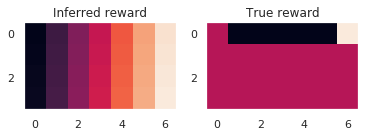

In [5]:
# Same experiments, but on grid world
mdp = menv.CliffWorld(
    width=7,
    height=4,
    horizon=8,
    use_xy_obs=True)
V, Q, pi = tirl.mce_partition_fh(mdp)
Dt, D = tirl.mce_occupancy_measures(mdp, pi=pi)
demo_counts = D @ mdp.observation_matrix
obs_dim, = demo_counts.shape
rmodel = tirl.LinearRewardModel(obs_dim)
opt = tirl.AMSGrad(rmodel, alpha_sched=1)
final_weights, D_fake = tirl.maxent_irl(
    mdp, opt, rmodel, D, linf_eps=0.1)

mdp.draw_value_vec(D)
plt.title("Cliff World $p(s)$")
plt.xlabel('x-coord')
plt.ylabel('y-coord')
plt.show()

mdp.draw_value_vec(D_fake)
plt.title("Occupancy for linear reward function")
plt.show()
plt.subplot(1, 2, 1)
mdp.draw_value_vec(rmodel.out(mdp.observation_matrix))
plt.title("Inferred reward")
plt.subplot(1, 2, 2)
mdp.draw_value_vec(mdp.reward_matrix)
plt.title("True reward")
plt.show()

Occupancy measure error@iter   0: 1.734850 (||params||=3.436170, ||grad||=7.315571, ||E[dr/dw]||=13.208749)
Occupancy measure error@iter  250: 0.399144 (||params||=8.228056, ||grad||=0.576444, ||E[dr/dw]||=41.590051)
Occupancy measure error@iter  500: 0.179033 (||params||=10.103688, ||grad||=0.334714, ||E[dr/dw]||=49.168805)
Occupancy measure error@iter  750: 0.104646 (||params||=11.412536, ||grad||=0.196661, ||E[dr/dw]||=54.055745)
Occupancy measure error@iter  1000: 0.076170 (||params||=12.342168, ||grad||=0.156521, ||E[dr/dw]||=56.786908)
Occupancy measure error@iter  1250: 0.059434 (||params||=13.036484, ||grad||=0.113909, ||E[dr/dw]||=59.026142)
Occupancy measure error@iter  1500: 0.048378 (||params||=13.594294, ||grad||=0.116399, ||E[dr/dw]||=60.657570)
Occupancy measure error@iter  1750: 0.040731 (||params||=14.061352, ||grad||=0.087111, ||E[dr/dw]||=62.685958)
Occupancy measure error@iter  2000: 0.034844 (||params||=14.468188, ||grad||=0.104398, ||E[dr/dw]||=65.179337)
Occupanc

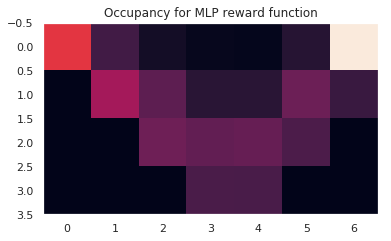

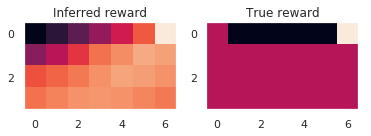

In [6]:
rmodel = tirl.MLPRewardModel(obs_dim, [1024,], activation='Relu')
opt = tirl.AMSGrad(rmodel, alpha_sched=1e-3)
final_weights, D_fake_mlp = tirl.maxent_irl(
    mdp, opt, rmodel, D, linf_eps=3e-2, print_interval=250)
mdp.draw_value_vec(D_fake_mlp)
plt.title("Occupancy for MLP reward function")
plt.show()
plt.subplot(1, 2, 1)
mdp.draw_value_vec(rmodel.out(mdp.observation_matrix))
plt.title("Inferred reward")
plt.subplot(1, 2, 2)
mdp.draw_value_vec(mdp.reward_matrix)
plt.title("True reward")
plt.show()

Notice that the inferred reward is absolutely nothing like the true reward, but the occupancy measure still (roughly) matches the true occupancy measure.